In [1]:
import sys
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')

import numpy as np
import collections
import gzip
import random

from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
from utils import readgtf

# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [2]:
SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

SNP_COMPLEMENT = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def HWEcheck(x):
    gt = x.tolist()
    f = np.array([0] * 3)
    f[0] = gt.count(0)
    f[1] = gt.count(1)
    f[2] = gt.count(2)
    n = sum(f)
    #p_A = (2 * f[0] + f[1]) / (2 * n)
    #p_a = (2 * f[2] + f[1]) / (2 * n)
    X2 = n * ( (4 * f[0] * f[2] - f[1] ** 2) / ((2 * f[0] + f[1]) * (2 * f[2] + f[1])) )**2
    pval = 1 - stats.chi2.cdf(X2, 1)
    return pval


def filter_snps(snpinfo, dosage):
        # Predixcan style filtering of snps
        newsnps = list()
        newdosage = list()
        npoly = 0
        nambi = 0
        nunkn = 0
        nlowf = 0
        nlowf_actual = 0
        nhwep = 0
        maf_limit = 0.01
        for i, snp in enumerate(snpinfo):
            pos = snp.bp_pos
            refAllele = snp.ref_allele
            effectAllele = snp.alt_allele
            rsid = snp.varid
            maf = round(snp.maf, 3)
            maf_actual = sum(dosage[i]) / 2 / len(dosage[i])
            # Skip non-single letter polymorphisms
            if len(refAllele) > 1 or len(effectAllele) > 1:
                npoly += 1
                continue
            # Skip ambiguous strands
            if SNP_COMPLEMENT[refAllele] == effectAllele:
                nambi += 1
                continue
            # Skip unknown RSIDs
            if rsid == '.':
                nunkn += 1
                continue
            # Skip low MAF
            if not (maf >= maf_limit and maf <= (1 - maf_limit)):
                nlowf += 1
                continue
            if not (maf_actual >= maf_limit and maf_actual <= (1 - maf_limit)):
                nlowf_actual += 1
                continue
            # if np.all(dosage[i] == dosage[i][0:]):
            #     nsame += 1
            #     continue
            # # Convert to integers 0, 1 or 2
            # bins = [0.66, 1.33]
            # intdosage = np.digitize(dosage[i], bins)
            # # Remove SNPs out of HWE
            # hwep = self.HWEcheck(intdosage)
            # if(hwep < 0.000001):
            #    nhwep += 1
            #    # self.logger.debug("SNP {:s} has a HWE p-value of {:g}".format(rsid, hwep))
            #    continue
            new_snp = snp._replace(maf = maf_actual)
            newsnps.append(new_snp)
            newdosage.append(dosage[i])
            # newdosage.append(intdosage)
        print("Removed {:d} SNPs because of non-single letter polymorphisms".format(npoly))
        print("Removed {:d} SNPs because of ambiguous strands".format(nambi))
        print("Removed {:d} SNPs because of unknown RSIDs".format(nunkn))
        print("Removed {:d} SNPs because of low MAF < {:g}".format(nlowf, maf_limit))
        print("Removed {:d} SNPs because of low MAF (current)".format(nlowf_actual))
        # self.logger.debug("Removed {:d} SNPs because of deviation from HWE".format(nhwep))
        return newsnps, np.array(newdosage)   

def read_vcf(filename, startsnp, endsnp, mode="DS"):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    if linesplit[0].startswith("chr"):
                        chrom = int(linesplit[0][3:])
                    else:
                        chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    if mode == "DS":
                        if "DS" not in linesplit[8].split(':'):
                            mode = "GT"
                        else:
                            dsindx = linesplit[8].split(':').index("DS")
                            ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                            gtindx = linesplit[8].split(':').index("GT")
                            for i, x in enumerate(ds):
                                if x == ".":
                                    gt = linesplit[9+i].split(':')[gtindx]
                                    if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                        ds[i] = float(int(gt[0]) + int(gt[2]))

                    if mode == "GT":
                        if "GT" not in linesplit[8].split(':'):
                            print("ERROR: no GT field in VCF file")
                            raise
                        gtindx = linesplit[8].split(':').index("GT")
                        gt = [x.split(':')[gtindx] for x in linesplit[9:]]
                        ds = [ float(int(x[0]) + int(x[2])) if len(x) == 3 and x[0] != "." and x[2] != "." else "." for x in gt ]

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1
                
                if linenum > endsnp:
                    break
    return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def select_genes(info, names):
    ''' Select genes which would be analyzed. 
        Make sure the indices are not mixed up
    '''
    allowed = [x.ensembl_id for x in info]
    common  = [x for x in names if x in allowed]
    genes = [x for x in info if x.ensembl_id in common]
    indices = [names.index(x.ensembl_id) for x in genes]
    return genes, np.array(indices)

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtnorm = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtnorm, gtcent #rr uses gtcent

def sample_gt(snpinfo, nsample):
    nsnps = len(snpinfo)
    dosages = np.zeros(nsnps * nsample)
    i = 0
    for snp in snpinfo:
        gtcent = sample_from_maf(nsample, snp.maf)
        dosages[i,:] = gtcent
        i += 1
    return dosages    

def sample_from_maf(nsample, maf):
    dosage = np.zeros(nsample)
    mafratios = np.array([(1 - maf)**2, 2 * maf * (1 - maf), maf**2])
    nfreq  = np.random.multinomial(nsample, mafratios, size=1)[0]
    f1 = np.repeat(0, nfreq[0])
    f2 = np.repeat(1, nfreq[1])
    f3 = np.repeat(2, nfreq[2])
    x  = np.concatenate((f1,f2,f3))
    dosage = np.random.permutation(x)
    # gtnorm = (dosage - (2 * maf2d)) / np.sqrt(2 * maf2d * (1 - maf2d))
    gtcent = dosage - np.mean(dosage)

    return gtcent

def simulate_gt(nsnps, nsample):
    mafs = np.linspace(0.1, 0.9, nsnps)
    gtcent = np.zeros((nsnps, nsample))
    snpinfo = list()
    for i in range(nsnps):
        gtcent[i,:] = sample_from_maf(nsample, mafs[i])
        this_snp = SnpInfo(chrom      = 1,
                           bp_pos     = i*100,
                           varid      = "rsid"+str(i),
                           ref_allele = "A",
                           alt_allele = "G",
                           maf        = mafs[i])
        snpinfo.append(this_snp)
    return gtcent, snpinfo

CISMASK_FIELDS = ['rmv_id', 'apply2']
class CisMask(collections.namedtuple('_CisMask', CISMASK_FIELDS)):
    __slots__ = ()

    @property
    def nsnp(self):
        return len(self.apply2)

    def __repr__(self):
        parent_string = super(CisMask, self).__repr__()
        return '{:s}, nsnp = {:d}'.format(parent_string, self.nsnp)

def get_cismasklist(snpinfo, geneinfo, chrom, window=1e6):
    chr_genes_ix = [[] for ichrm in range(22)] 
    chr_genes = [[] for ichrm in range(22)]
    if chrom is not None:
        chr_genes_ix[chrom - 1] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == chrom])
        chr_genes[chrom - 1] = [geneinfo[ix] for ix in chr_genes_ix[chrom - 1]]
    else:
        for ichrm in range(22):
            chr_genes_ix[ichrm] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == ichrm + 1])
            chr_genes[ichrm] = [geneinfo[ix] for ix in chr_genes_ix[ichrm]]
    genemasks = list()
    iprev = 0
    ichrmprev = 0
    for snp in snpinfo:
        pos = snp.bp_pos
        left = pos - window
        right = pos + window
        ichrm = chrom - 1 if chrom is not None else snp.chrom - 1
        iprev_started = False
        if ichrm != ichrmprev:
            iprev = 0
            ichrmprev = ichrm
        thismask = list()
        for i, g in enumerate(chr_genes[ichrm][iprev:]):
            gstart = g.start
            gend = g.end
            if gstart >= left and gstart <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            elif gend >= left and gend <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            if gstart > right:
                break
        if len(thismask) > 0:
            #genemasks.append(chr_genes_ix[np.array(thismask)])
            #iprev = thismask[0]
            genemasks.append(np.array(thismask))
            iprev = new_start_iloc
        else:
            genemasks.append(np.array([]))
    return genemasks

def compress_cismasklist(genemasks):
    cismasks = list()
    appendmask = False
    endmask = False
    setprev = False
    snplist = list()
    for i, mask in enumerate(genemasks):
        if not setprev:
            prev_mask = mask
            setprev = True
        if np.all(np.array_equal(mask, prev_mask)):
            snplist.append(i)
        else:
            appendmask = True

        if i == len(genemasks) - 1: endmask = True # no more masks to process

        if appendmask:
            thismask = CisMask(rmv_id = prev_mask, apply2 = snplist)
            cismasks.append(thismask)
            snplist = list([i])
            prev_mask = mask
            if not endmask:
                appendmask = False

        if endmask:
            # if not appendmask:
            #     snplist.append(i)
            thismask = CisMask(rmv_id = mask, apply2 = snplist)
            cismasks.append(thismask)

    return cismasks

def knn_correction_old(expr, dosage):
    pca = PCA(n_components=min(expr.shape[0], expr.shape[1]))
    print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
    print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = 30
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, neighbors[1:]], axis = 1)

    return gx_knn, gt_knn

def knn_correction(expr, dosage, K, f=1):
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1]) ))
    print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
    print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

In [3]:
gencode_file = "/cbscratch/franco/datasets/GENCODE/gencode.v26.annotation.gtf.gz"
geneinfo = readgtf.gencode_v12(gencode_file, biotype = ["protein_coding", "lncRNA"])

Mode v26


In [4]:
# # Simulate some expression
# ngene = 15000
# nsample = 350
# gx_rand = np.random.normal(0, 1, size = nsample * ngene).reshape((ngene, nsample)) 
# gx_donors = random.sample(gt_donors, nsample)
# print(gx_rand.shape)

# Load real expression
import pandas as pd
tissue="as"
df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
# df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.collinear_filtered.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = df.values
gene_names = list(df.index)
print(gx.shape)
print(np.linalg.matrix_rank(gx))


(15761, 581)
580


In [5]:
# Use real genotype
chrm=12
f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_0.01/GTEX_v8_2019-07-29_WGS_838Indiv_Freeze_NoMissingGT_SNPfilter_MAF0.01_chr{:d}.vcf.gz".format(chrm)
gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 10000)

import copy
vcfmask, exprmask = select_donors(gt_donors, gx_donors)
genes, indices = select_genes(geneinfo, gene_names)
dosage_masked = gtfull[:, vcfmask]

snp_info, dosage = filter_snps(snpinfos, dosage_masked)


# Use artificial genotype
# gtfull, snp_info = simulate_gt(10000, len(gt_donors))


Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 0 SNPs because of low MAF < 0.01
Removed 278 SNPs because of low MAF (current)


In [6]:
# # PCA correction - Won't work: makes some singular values == 0
# nComp = 5
# pca = PCA()
# pca.fit(gx_rand.T)
# gx_rand_pca = np.dot(pca.transform(gx_rand.T)[:, nComp:], pca.components_[nComp:,:]).T
# print(gx_rand_pca.shape)
# gx_rand_pca_norm = normalize_expr(gx_rand_pca[:, exprmask]) #/ np.sqrt(nsample)


In [7]:
gx_norm = normalize_expr( gx[:, exprmask] )

## --- Apply KNN correction
f=1
gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)
gx_knn60, gt_knn60 = knn_correction(gx_norm.T, dosage, K=60, f=f)
gx_knn15, gt_knn15 = knn_correction(gx_norm.T, dosage, K=15, f=f)

## --- Normalize GX and GT
gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
sigmax2     = np.var(gt_cent, axis = 1)

gx_knn_norm = normalize_expr(gx_knn.T)
gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
sigmax2_knn = np.var(gt_knn_cent, axis = 1)

gx_knn_norm60 = normalize_expr(gx_knn60.T)
gt_knn_norm60, gt_knn_cent60 = normalize_and_center_dosage(gt_knn60, snp_info)
sigmax2_knn60 = np.var(gt_knn_cent60, axis = 1)

gx_knn_norm15 = normalize_expr(gx_knn15.T)
gt_knn_norm15, gt_knn_cent15 = normalize_and_center_dosage(gt_knn15, snp_info)
sigmax2_knn15 = np.var(gt_knn_cent15, axis = 1)

shuffle_mask = np.arange(nsample)
np.random.shuffle(shuffle_mask)
gx_shuffled_norm = copy.deepcopy(gx_norm[:, shuffle_mask])
gx_shuffled_knn_norm = copy.deepcopy(gx_knn_norm[:, shuffle_mask])
gx_shuffled_knn_norm60 = copy.deepcopy(gx_knn_norm60[:, shuffle_mask])
gx_shuffled_knn_norm15 = copy.deepcopy(gx_knn_norm15[:, shuffle_mask])

Original dimension: 581 x 15761
Reduced dimension: 581 x 581
Original dimension: 581 x 15761
Reduced dimension: 581 x 581
Original dimension: 581 x 15761
Reduced dimension: 581 x 581


In [8]:
## --- Obtain CisMasks

cismasklist = get_cismasklist(snp_info, genes, chrm, window=1e6)
cismaskcomp = compress_cismasklist(cismasklist)

13307.633952921668


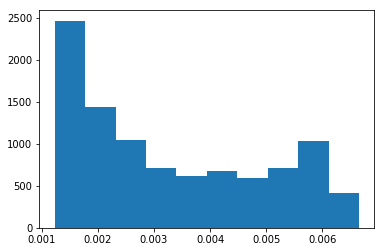

In [16]:
Y = gx_norm # / np.sqrt(nsample)
Yt = Y.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
s2_median = np.median(np.square(S))
print(s2_median)
# SIGMA_BETAS = np.repeat(0.1, gt_cent.shape[0])
SIGMA_BETAS = np.sqrt( sigmax2 / s2_median )
plt.hist(SIGMA_BETAS)
plt.show()

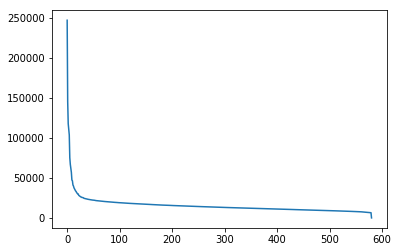

In [17]:
plt.plot(np.square(S))
plt.show()

In [10]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) + v22*(q2**2 + 2*q22 - 3*q4) + 4*v31*(q31 - q4) + mu4*q4

    sigma2 = sigma2 - muQ**2
    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

====== Norm - no KNN ======
====== Norm Shuffled - no KNN ======
====== Norm KNN ======
====== Shuffled Norm KNN ======
====== Norm KNN 60 ======
====== Shuffled Norm KNN 60 ======
====== Norm KNN15 ======
====== Shuffled Norm KNN15 ======


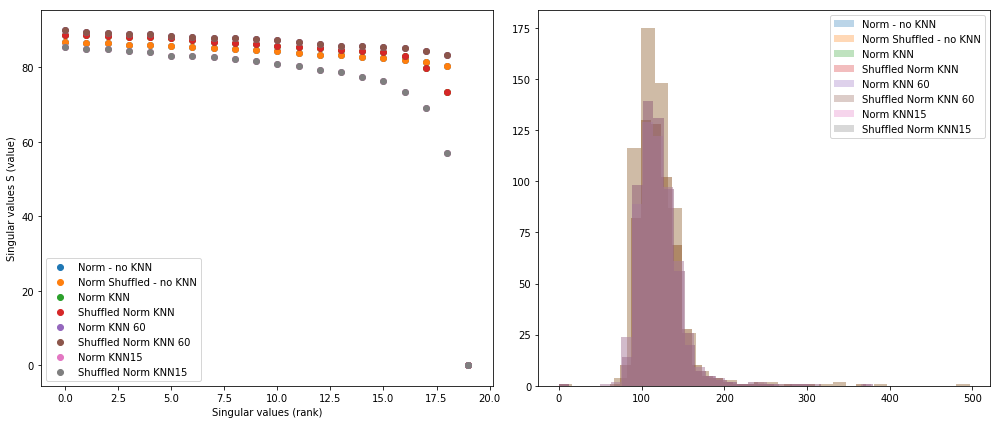

In [11]:
def compare_basic_props(GX, GT, ax1, ax2, label, sigmax2 = [0.1], sb2 = None, Ucorr = False, cismask = None):
    
    if cismask is None:
        nsnps = GT.shape[0]
        myGT = GT
        myGX = GX
    else:
        usegenes = np.ones(GX.shape[0], dtype=bool)
        if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
        myGX = GX[usegenes]
        myGT = GT[cismask.apply2,:]
        nsnps = myGT.shape[0]
        
    
    # Yt = (GX / np.sqrt(nsample)).T
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S, dtype=np.float64 )
    
    ax1.scatter(np.arange(len(S[-20:])), S[-20:], label = label)
    ax2.hist(S, bins=30, alpha=0.3, label = label)
    
    K = np.linalg.matrix_rank(myGX)
    print("====== {:s} ======".format(label))
        
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    mu2    = np.zeros(nsnps)
    mu4    = np.zeros(nsnps)
    Keffs  = np.zeros(nsnps)
    for j in range(nsnps):       
        S2mod = S2 + (sigmax2[j] / sb2[j])

        W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2[j]
        Rscore[j] = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2[j]
        
        pvals[j], muQ[j], sigmaQ[j] = pvals_perm(myGT[j, :].reshape(1, -1), Rscore[j], W)
        # mu2[j], mu4[j] = moment_data(myGT[j, :].reshape(1, -1))
        
    return S2, pvals, Rscore, muQ, sigmaQ

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sb2 = np.square(SIGMA_BETAS)

# - No KNN
nS2, npvals, nQ, nmuQ, nscaledQ = compare_basic_props(gx_norm, gt_cent, ax1, ax2, 'Norm - no KNN', sigmax2 = sigmax2, sb2 = sb2, cismask=cismaskcomp[0])
shuf_nS2, shuf_npvals, shuf_nQ, shuf_nmuQ, shuf_nscaledQ = compare_basic_props(gx_shuffled_norm, gt_cent, ax1, ax2, 'Norm Shuffled - no KNN', sigmax2 = sigmax2, sb2 = sb2, cismask=cismaskcomp[0])

# - With KNN
S2, pvals, Q, muQ, scaledQ = compare_basic_props(gx_knn_norm, gt_knn_cent, ax1, ax2, 'Norm KNN', sigmax2 = sigmax2_knn, sb2 = sb2, cismask=cismaskcomp[0])
shuf_S2, shuf_pvals, shuf_Q, shuf_muQ, shuf_scaledQ = compare_basic_props(gx_shuffled_knn_norm, gt_knn_cent, ax1, ax2, 'Shuffled Norm KNN', sigmax2 = sigmax2_knn, sb2 = sb2, cismask=cismaskcomp[0])

# # - With KNN
S260, pvals60, Q60, muQ60, scaledQ60 = compare_basic_props(gx_knn_norm60, gt_knn_cent60, ax1, ax2, 'Norm KNN 60', sigmax2 = sigmax2_knn60, sb2 = sb2, cismask=cismaskcomp[0])
shuf_S260, shuf_pvals60, shuf_Q60, shuf_muQ60, shuf_scaledQ60 = compare_basic_props(gx_shuffled_knn_norm60, gt_knn_cent60, ax1, ax2, 'Shuffled Norm KNN 60', sigmax2 = sigmax2_knn60, sb2 = sb2, cismask=cismaskcomp[0])

# # # - With KNN
S215, pvals15, Q15, muQ15, scaledQ15 = compare_basic_props(gx_knn_norm15, gt_knn_cent15, ax1, ax2, 'Norm KNN15', sigmax2 = sigmax2_knn15, sb2 = sb2, cismask=cismaskcomp[0])
shuf_S215, shuf_pvals15, shuf_Q15, shuf_muQ15, shuf_scaledQ15 = compare_basic_props(gx_shuffled_knn_norm15, gt_knn_cent15, ax1, ax2, 'Shuffled Norm KNN15', sigmax2 = sigmax2_knn15, sb2 = sb2, cismask=cismaskcomp[0])

ax1.set_xlabel("Singular values (rank)")
ax1.set_ylabel("Singular values S (value)")
ax1.legend()

ax2.legend()
plt.tight_layout()
plt.show()


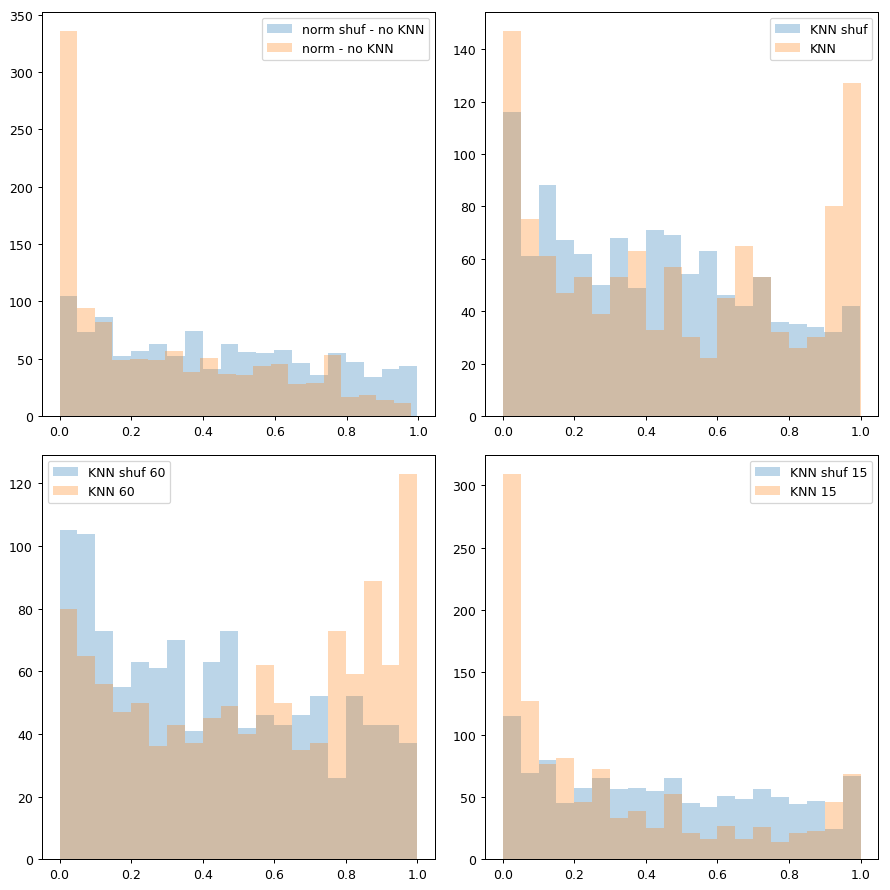

In [12]:
fig = plt.figure(figsize=(10,10), dpi=90)
ax1 = fig.add_subplot(2,2,1)
ax1.hist(shuf_npvals, bins=20, alpha=0.3, label="norm shuf - no KNN")
ax1.hist(npvals, bins=20, alpha=0.3, label="norm - no KNN")
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.hist(shuf_pvals, bins=20, alpha=0.3, label="KNN shuf")
ax2.hist(pvals, bins=20, alpha=0.3, label="KNN")
ax2.legend()

ax3 = fig.add_subplot(2,2,3)
ax3.hist(shuf_pvals60, bins=20, alpha=0.3, label="KNN shuf 60")
ax3.hist(pvals60, bins=20, alpha=0.3, label="KNN 60")
ax3.legend()

ax4 = fig.add_subplot(2,2,4)
ax4.hist(shuf_pvals15, bins=20, alpha=0.3, label="KNN shuf 15")
ax4.hist(pvals15, bins=20, alpha=0.3, label="KNN 15")
ax4.legend()

plt.tight_layout()
plt.show()


In [13]:
[snp_info[x] for x in np.where(pvals < 1e-5)[0]]

[]

In [14]:
pvals[:20]


array([0.4246313 , 0.10940658, 0.83208147, 0.92483519, 0.10940658,
       0.10940658, 0.303017  , 0.56226537, 0.8557996 , 0.93902232,
       0.80001332, 0.60095148, 0.36958649, 0.34701228, 0.27026453,
       0.10565701, 0.24735956, 0.58358757, 0.4226728 , 0.1873407 ])

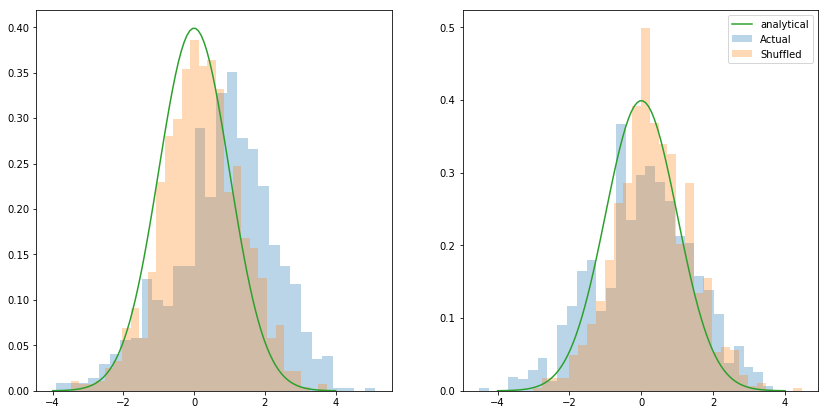

In [15]:
# - no KNN
# qscaled = (nQ - nmuQ)/ nscaledQ
# shuf_qscaled = (shuf_nQ - shuf_nmuQ)/ shuf_nscaledQ

# - KNN 15
qscaled = (Q15 - muQ15)/ scaledQ15
shuf_qscaled = (shuf_Q15 - shuf_muQ15)/ shuf_scaledQ15

# - KNN 30
qscaled2 = (Q - muQ)/ scaledQ
shuf_qscaled2 = (shuf_Q - shuf_muQ)/ shuf_scaledQ

# - KNN 60
# qscaled2 = (Q60 - muQ60)/ scaledQ60
# shuf_qscaled2 = (shuf_Q60 - shuf_muQ60)/ shuf_scaledQ60

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.hist(qscaled, bins=30, alpha=0.3, density=True, label="Actual")
ax1.hist(shuf_qscaled, bins=30, alpha=0.3, density=True, label="Shuffled")

ax2 = fig.add_subplot(122)
ax2.hist(qscaled2, bins=30, alpha=0.3, density=True, label="Actual")
ax2.hist(shuf_qscaled2, bins=30, alpha=0.3, density=True, label="Shuffled")

x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
ax1.plot(x, rv.pdf(x), label = 'analytical')
ax2.plot(x, rv.pdf(x), label = 'analytical')

plt.legend()
plt.show()